In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import collections
import functools
import abc
import random

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sobol_seq

import bvbq
import bvbq.gp

In [3]:
bvbq.gp

<module 'bvbq.gp' from '../bvbq/gp.py'>

In [4]:
ndim = 2
def exponential_quartic(x):
    x1,x2 = x[...,0],x[...,1]
    res = -0.1*x1**4 -0.5*(2*x2-x1**2)**2
#     return -0.5*((x1+1)**2 + (x2 - 1)**2)
    return res

W0730 10:14:06.606153 139716904834880 xla_bridge.py:137] No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


If tensor has more than 2 dimensions, only diagonal of covariance is returned


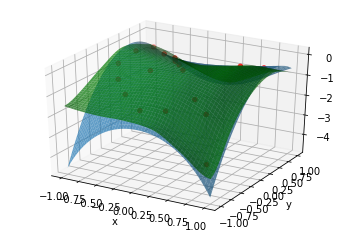

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)

xys = (2*(sobol_seq.i4_sobol_generate(2,20)-0.5)) #[-1,1] cube
zs = exponential_quartic(xys)
ax.scatter(xys[:,0],xys[:,1],zs,color='red')
ax.set_xlabel('x');
ax.set_ylabel('y');

gp = bvbq.gp.SimpleGP(2,kind='smatern32',noise=0)
gp.set_data(xys,zs,empirical_params=True)
gp.optimize_params()
Zreg = gp.predict(np.stack([X,Y],axis=-1))[0]
ax.plot_surface(X,Y,Zreg,alpha=0.7,color='green')

In [6]:
def inds_mean(x,inds,indrange):
    def ind_mean(i):
        return jnp.nan_to_num(jnp.mean(x[inds==i]))
    return jnp.stack([ind_mean(i) for i in indrange])

class ProbabilityDistribution(abc.ABC):
    def __init__(self,seed):
        self.seed = seed
        self.key = jax.random.PRNGKey(seed)
        self.ismixture = False
        
    def split_key(self):
        key,subkey = jax.random.split(self.key)
        self.key = key
        return subkey
    
    @abc.abstractmethod
    def logprob(self,x):
        pass
    
    @abc.abstractmethod
    def sample(self,n):
        pass

    @property
    @abc.abstractmethod
    def params(self):
        pass
    
    def monte_carlo_entropy(self,n):
        return -jnp.mean(self.logprob(self.sample(n)))

    
class DiagonalNormalDistribution(ProbabilityDistribution):
    def __init__(self,mean,var,seed=random.randint(1,1000)):
        super().__init__(seed)
        self.ndim = mean.shape[0]
        self.mean = mean
        self.var = var
        assert(len(self.var) == self.ndim)
        assert(len(self.mean) == self.ndim)
        self.std = jnp.sqrt(self.var)
    
    def logprob(self,x):
        res = -0.5*jnp.sum(((x-self.mean)/self.std)**2,axis=-1) \
              -jnp.sum(jnp.log(self.std)) - self.ndim/2*jnp.log(2*jnp.pi)
        return res
    
    def sample(self,n):
        subkey = self.split_key()
        z = jax.random.normal(subkey,shape=(n,self.ndim))
        res = self.mean + self.std*z
        return res
    
    def make_mixture(self):
        means = jnp.expand_dims(self.mean,0)
        variances = jnp.expand_dims(self.var,0)
        weights = jnp.ones(1)
        return MixtureDiagonalNormalDistribution(means,variances,weights)
    
    @property
    def params(self):
        return self.mean,self.var

    
class MixtureDiagonalNormalDistribution(ProbabilityDistribution):
    def __init__(self,means,variances,weights,seed=random.randint(1,1000)):
        super().__init__(seed)
        self.nmixtures = weights.shape[0]
        self.ndim = means.shape[1]
        self.means = means
        self.variances = variances
        self.weights = weights
        assert(self.variances.shape[1] == self.ndim)
        assert(self.means.shape[0] == self.nmixtures)
        assert(self.variances.shape[0] == self.nmixtures)
        self.stds = jnp.sqrt(variances)
        self.ismixture = True
        
    def logprob(self,x):
        #log(sum(alpha*exp(logprob_i(x))))
        #y_i := logprob_i(x)
        #y_max = jnp.max(y_i)
        #log(sum(alphai*exp(yi - ymax)*exp(ymax)))
        #ymax + log(sum(alphai*exp(yi-ymax)))
        #x : (n,d)
        #res : (n,)
        #y_i : (n,m)
        #y_max : (n,)
        #(alphai*exp(yi - ymax)) : (n,m)
        #means : (m,d)
        #stds : (m,d)
        #jnp.expand_dims()
        x = jnp.expand_dims(x,-2) #(n,1,d)
        yi1 = -0.5*jnp.sum(((x-self.means)/self.stds)**2,axis=-1) #(n,m)
        yi2 = -jnp.sum(jnp.log(self.stds),axis=-1) #(m,)
        yi3 = -self.ndim/2*jnp.log(2*jnp.pi) #(,)
        yi = yi1 + yi2 + yi3 #(n,m)
        ymax = jnp.max(yi,axis=-1,keepdims=True) #(n,1)
        sumexp = jnp.sum(self.weights*jnp.exp(yi-ymax),axis=-1)
        res = jnp.squeeze(ymax,axis=-1) + jnp.log(sumexp) #(n,)
        return res
        
    def sample(self,n):
        subkey = mixdistrib.split_key()
        catinds = jax.random.choice(subkey,self.nmixtures,shape=(n,),p=self.weights)
        z = jax.random.normal(subkey,shape=(n,self.ndim))
        res = self.means[catinds,:] + self.stds[catinds,:]*z
        return res
    
    @property
    def params(self):
        return self.means,self.variances,self.weights
    
    def add_component(self,mean,var,weight,return_new=False):
        weights = jnp.append((1-weight)*self.weights,weight)
        means = jnp.vstack([self.means,mean])
        variances = jnp.vstack([self.variances,var])
        if return_new:
            return MixtureDiagonalNormalDistribution(means,variances,weights)
        else:
            self.means = means
            self.variances = variances
            self.weights = weights
            self.stds = jnp.sqrt(variances)
            self.nmixtures += 1

In [7]:
x = np.random.rand(5,2)

distrib = DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
distrib.sample(100).mean(axis=0)
jnp.cov(distrib.sample(100),rowvar=False)

mixdistrib = distrib.make_mixture()
mixdistrib.add_component(jnp.ones(2),0.1*jnp.ones(2),0.1)
mixdistrib.add_component(2*jnp.ones(2),0.1*jnp.ones(2),0.1)
mixdistrib.logprob(x)

DeviceArray([-7.5130873, -4.664054 , -5.8828573, -8.043125 , -2.5045056],            dtype=float32)

In [8]:
mixdistrib.weights.shape

(3,)

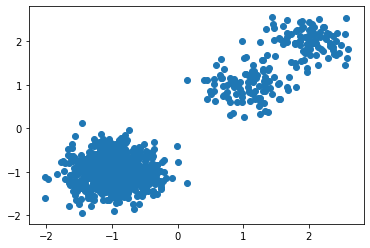

In [9]:
x = mixdistrib.sample(1000)
plt.scatter(x[:,0],x[:,1])

In [51]:
def monte_carlo_bayesian_quadrature(gp,distrib,nsamples):
    samples1 = distrib.sample(nsamples)
    samples2 = distrib.sample(nsamples)
    samples3 = distrib.sample(nsamples)
    z = gp.kernel_function(gp.X,samples1).mean(axis=-1,keepdims=True) #(m,1)
    gamma = gp.kernel_function(samples2,samples3,diagonal=True).mean()
    y_ = jax.scipy.linalg.solve_triangular(gp.upper_chol_matrix,
                                           gp.y-gp.mean,
                                           trans='T') #(m,1)
    z_ = jax.scipy.linalg.solve_triangular(gp.upper_chol_matrix,
                                           z,
                                           trans='T') #(m,1)
    mean = gp.mean + z_.transpose()@y_
    var = gamma - z_.transpose()@z_
    return mean,var

def false_monte_carlo_bayesian_quadrature(gp,distrib,nsamples):
    samples = distrib.sample(nsamples)
    mean = jnp.mean(gp.predict(distrib.sample(nsamples),return_cov=False))
    return mean

def logprob_quadrature(logprob,distrib,nsamples):
    return jnp.mean(logprob(distrib.sample(nsamples)))

def elbo(logprob,distrib,nsamples):
    term1 = distrib.monte_carlo_entropy(nsamples)
    term2 = logprob_quadrature(logprob,distrib,nsamples)
    return term1 + term2

def boosted_elbo(logprob,distrib,newcomp,newweight,nsamples):
    samples_distrib = distrib.sample(nsamples)
    samples_newcomp = newcomp.sample(nsamples)
    print(*newcomp.params)
    print(*distrib.params)
    joint_distrib = distrib.add_component(*newcomp.params,newweight,return_new=True)
    logprob_mean_1 = logprob(samples_distrib).mean()
    partial_entropy_1 = -joint_distrib.logprob(samples_distrib).mean()
    logprob_mean_2 = logprob(samples_newcomp).mean()
    partial_entropy_2 = -joint_distrib.logprob(samples_newcomp).mean()
    res = (1-newweight)*(logprob_mean_1 + partial_entropy_1) + \
          newweight*(logprob_mean_2 + partial_entropy_2)
    return res

def vbq_elbo(gp,distrib,nsamples):
    term1 = distrib.monte_carlo_entropy(nsamples)
#     term2,_ = monte_carlo_bayesian_quadrature(gp,distrib,nsamples)
#     term2 = term2[0][0]
    term2 = false_monte_carlo_bayesian_quadrature(gp,distrib,nsamples)
    return term1 + term2

def relbo(logprob,distrib,newcomp,nsamples,reg,epsilon=1e-10):
    samples = newcomp.sample(nsamples)
    negentropy = newcomp.logprob(samples).mean() #-(-E[log(q)])
    logprobmean = logprob(samples).mean()
    distlogprob = distrib.logprob(samples)
    clippeddistlogprob = jnp.clip(distlogprob,0.0,None)
    regdistlogprob = clippeddistlogprob \
                     *(jnp.exp(distlogprob-clippeddistlogprob) + \
                       jnp.exp(-clippeddistlogprob))
    negdistribmean = -regdistlogprob.mean()
    res = logprobmean + negdistribmean + reg*negentropy
    return res
    #log(exp(d)+delta*exp(0))
    #max(d,0) + logprob(exp(d-max(d,0)) + delta*exp(-max(d,0)))
    #logprob

In [52]:
def objective_function_relbo(params,mixdistrib):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    newcomp = DiagonalNormalDistribution(mean,var)
    res = -relbo(exponential_quartic,mixdistrib,newcomp,1000,1e-2)
    return res

def objective_function_gradboost(weight,distrib,mixdistrib):
    res = -boosted_elbo(exponential_quartic,mixdistrib,distrib,weight,1000)
    return res

params = {'mean':jnp.zeros(2),'rawvar':jnp.zeros(2)}
distrib = DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
mixdistrib = distrib.make_mixture()
distrib = DiagonalNormalDistribution(-jnp.ones(2)+0.1,0.1*jnp.ones(2)+0.2)
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_relbo(params,mixdistrib))
weight = 0.5
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost)
print(func_and_grad_gradboost(0.5,distrib,mixdistrib))

(DeviceArray(2.1982174, dtype=float32), {'mean': DeviceArray([ 0.20050076, -1.333035  ], dtype=float32), 'rawvar': DeviceArray([1.1884024 , 0.98049843], dtype=float32)})
[-0.9 -0.9] [0.3 0.3]
[[-1. -1.]] [[0.1 0.1]] [1.]
(DeviceArray(4.136026, dtype=float32), DeviceArray(-0.85651875, dtype=float32))


In [53]:
for k in range(10):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(2,)),
              'rawvar':jax.random.normal(mixdistrib.split_key(),(2,))}
    alpha = 1e-1
    maxiter = 100
    for i in range(maxiter):
        res,grads = func_and_grad_relbo(params,mixdistrib)
        for key,_ in params.items():
            params[key] -= alpha*grads[key]
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    distrib = DiagonalNormalDistribution(mean,var)
    weight = 1e-4
    for i in range(maxiter):
        res,gradweight = func_and_grad_gradboost(weight,distrib,mixdistrib)
        weight -= alpha*(0.9)**i*gradweight
        print(res,gradweight)
        weight = jnp.clip(weight,1e-4,1-1e-4)
#     mixdistrib.add_component(mean,var,weight)
    print(i,mean,var,weight)
    print('--')

KeyboardInterrupt: 

In [18]:
jnp.clip(weight,1e-4,1-1e-4)

DeviceArray(0.5, dtype=float32)

In [439]:
def objective_function_boost(params,mixdistrib):
    mean,rawvar,rawweight = params['mean'],params['rawvar'],params['rawweight']
    var = jax.nn.softplus(rawvar)
    weight = jax.nn.sigmoid(rawweight)
    newcomp = DiagonalNormalDistribution(mean,var)
    res = -boosted_elbo(exponential_quartic,mixdistrib,newcomp,weight,1000)
    return res

In [444]:
params = {'mean':jnp.zeros(2),'rawvar':jnp.zeros(2),'rawweight':0.0}
distrib = DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
mixdistrib = distrib.make_mixture()
func_and_grad_boost = jax.value_and_grad(objective_function_boost,argnums=0)
print(func_and_grad_boost(params,mixdistrib))
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_boost(params,mixdistrib))

(DeviceArray(1.887896, dtype=float32), {'mean': DeviceArray([-0.20847823, -0.89695036], dtype=float32), 'rawvar': DeviceArray([0.52817196, 0.34996378], dtype=float32), 'rawweight': DeviceArray(-1.1947603, dtype=float32)})
(DeviceArray(1.8134712, dtype=float32), {'mean': DeviceArray([-0.21127434, -0.8966506 ], dtype=float32), 'rawvar': DeviceArray([0.529354  , 0.35028124], dtype=float32), 'rawweight': DeviceArray(-1.1577396, dtype=float32)})


In [417]:
for k in range(10):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(2,)),
              'rawvar':jax.random.normal(mixdistrib.split_key(),(2,)),
              'rawweight':jax.random.normal(mixdistrib.split_key())}
    alpha = 1e-1
    maxiter = 100
    for i in range(maxiter):
        res,grads = func_and_grad(params,mixdistrib)
        for key,_ in params.items():
            params[key] -= alpha*grads[key]
        print(i)
    mean,rawvar,rawweight = params['mean'],params['rawvar'],params['rawweight']
    var = jax.nn.softplus(rawvar)
    weight = jax.nn.sigmoid(rawweight)
    mixdistrib.add_component(mean,var,weight)
    print(i,mean,var,weight)
    print('--')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
99 [0.03089201 0.2553121 ] [0.42370734 0.23237449] 0.96405953
--
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
99 [0.6334528  0.33187643] [0.19454661 0.31128526] 0.46900955
--
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


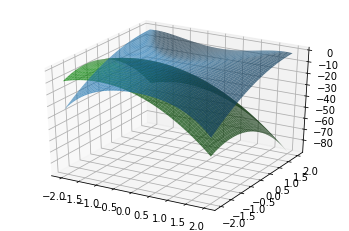

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-2,2)
y = np.linspace(-2,2)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)


Zboost = mixdistrib.logprob(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Zboost,alpha=0.7,color='green')

In [48]:
def logprob_t(x,nu):
    normalizer = jax.scipy.special.gammaln((nu+1)/2) \
                 -jax.scipy.special.gammaln(nu/2) \
                 -0.5*jnp.log(jnp.pi*nu)
    main_term = -(nu+1)/2*jnp.log(1+x**2/nu)
    return main_term + normalizer

def objective_function_relbo_2(params,mixdistrib):
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    newcomp = DiagonalNormalDistribution(mean,var)
    logprob = functools.partial(logprob_t,nu=2.5)
    res = -relbo(logprob,mixdistrib,newcomp,1000,1e-2)
    return res

def objective_function_gradboost_2(weight,distrib,mixdistrib):
    logprob = functools.partial(logprob_t,nu=2.5)
    res = -boosted_elbo(logprob,mixdistrib,distrib,weight,1000)
    return res

params = {'mean':jnp.zeros(1),'rawvar':jnp.zeros(1)}
distrib = DiagonalNormalDistribution(-jnp.ones(2),0.1*jnp.ones(2))
mixdistrib = distrib.make_mixture()
distrib = DiagonalNormalDistribution(-jnp.ones(2)+0.1,0.1*jnp.ones(2)+0.2)
func_and_grad_relbo = jax.value_and_grad(objective_function_relbo_2,argnums=0)
func_and_grad_relbo(params,mixdistrib)
print(func_and_grad_relbo(params,mixdistrib))
weight = 0.5
func_and_grad_gradboost = jax.value_and_grad(objective_function_gradboost_2)
print(func_and_grad_gradboost(0.5,distrib,mixdistrib))

(DeviceArray(1.4454538, dtype=float32), {'mean': DeviceArray([-0.08115812], dtype=float32), 'rawvar': DeviceArray([0.21923004], dtype=float32)})
(DeviceArray(0.35402858, dtype=float32), DeviceArray(-1.0606247, dtype=float32))


In [50]:
for k in range(10):
    params = {'mean':jax.random.normal(mixdistrib.split_key(),(1,)),
              'rawvar':jax.random.normal(mixdistrib.split_key(),(1,))}
    alpha = 1e-1
    maxiter = 100
    for i in range(maxiter):
        res,grads = func_and_grad_relbo(params,mixdistrib)
        for key,_ in params.items():
            params[key] -= alpha*grads[key]
    mean,rawvar = params['mean'],params['rawvar']
    var = jax.nn.softplus(rawvar)
    distrib = DiagonalNormalDistribution(mean,var)
    weight = 1e-4
    for i in range(maxiter):
        res,gradweight = func_and_grad_gradboost(weight,distrib,mixdistrib)
        weight -= alpha*(0.9)**i*gradweight
        print(res,gradweight)
        weight = jnp.clip(weight,1e-4,1-1e-4)
#     mixdistrib.add_component(mean,var,weight)
    print(i,mean,var,weight)
    print('--')

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 0 for shapes (1, 2), (1, 1).

In [40]:
jax.scipy.special.gammaln(3)

DeviceArray(0.6931474, dtype=float32)

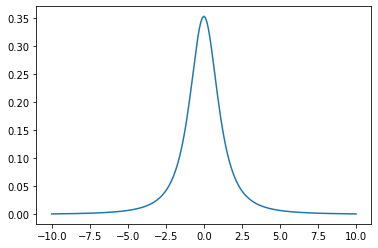

In [45]:
x = np.linspace(-10,10,201)
y = logprob(x,2)
plt.plot(x,np.exp(y))

In [419]:
def objective_function(params):
    mean,rawvar = params['mean'],params['rawvar']
    var = jnp.log(1+jnp.exp(rawvar))
    distrib = DiagonalNormalDistribution(mean,var)
    print(distrib.sample(1000).mean(axis=0))
    res = -elbo(exponential_quartic,distrib,1000)
    return res

In [420]:
params = {'mean':jnp.zeros(2),'rawvar':jnp.zeros(2)}
func_grad = jax.value_and_grad(objective_function)
alpha = 1e-1
maxiter = 50
for i in range(maxiter):
    res,grads = func_grad(params)
    for key,_ in params.items():
        params[key] -= alpha*grads[key]
    print(params['mean'],params['rawvar'],res)
mean,rawvar = params['mean'],params['rawvar']
var = jnp.log(1+jnp.exp(rawvar))
distrib = DiagonalNormalDistribution(mean,var)

Traced<ConcreteArray([-0.0135266  -0.03852437])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-0.0135266 , -0.03852437], dtype=float32)
       tangent = Traced<ShapedArray(float32[2]):JaxprTrace(level=1/0)>
[0.01218348 0.14070289] [-0.10029965 -0.0596782 ] -0.19883347
Traced<ConcreteArray([-0.00085734  0.10300419])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([-0.00085734,  0.10300419], dtype=float32)
       tangent = Traced<ShapedArray(float32[2]):JaxprTrace(level=1/0)>
[0.01763215 0.21488044] [-0.16946155 -0.11638688] -0.47044277
Traced<ConcreteArray([0.00492195 0.17795958])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.00492195, 0.17795958], dtype=float32)
       tangent = Traced<ShapedArray(float32[2]):JaxprTrace(level=1/0)>
[0.02077164 0.252686  ] [-0.22116733 -0.17012504] -0.58523166
Traced<ConcreteArray([0.00830612 0.21649575])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.00830612, 0.21649575], dtype=float32)
       tangent = Traced<Shape

[0.02442295 0.2230009 ] [-0.60026366 -0.9283175 ] -0.95709914
Traced<ConcreteArray([0.0136778 0.1962968])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.0136778, 0.1962968], dtype=float32)
       tangent = Traced<ShapedArray(float32[2]):JaxprTrace(level=1/0)>
[0.02438515 0.22226298] [-0.6037827  -0.94050646] -0.95883536
Traced<ConcreteArray([0.0136553  0.19569708])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.0136553 , 0.19569708], dtype=float32)
       tangent = Traced<ShapedArray(float32[2]):JaxprTrace(level=1/0)>
[0.02435094 0.2215796 ] [-0.6070609 -0.9521506] -0.9604127
Traced<ConcreteArray([0.01363533 0.19514517])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.01363533, 0.19514517], dtype=float32)
       tangent = Traced<ShapedArray(float32[2]):JaxprTrace(level=1/0)>
[0.02432    0.22094646] [-0.6101154  -0.96327704] -0.96184677
Traced<ConcreteArray([0.01361767 0.19463734])>with<JVPTrace(level=2/0)>
  with primal = DeviceArray([0.01361767, 0.19463734

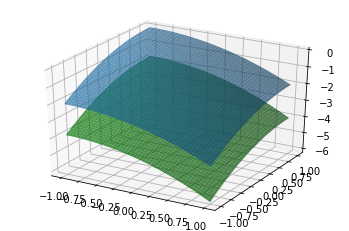

In [382]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
x = np.linspace(-1,1)
y = np.linspace(-1,1)
X,Y = np.meshgrid(x,y)
Z = exponential_quartic(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Z,alpha=0.7)


Zboost = distrib.logprob(np.stack([X,Y],axis=-1))
ax.plot_surface(X,Y,Zboost,alpha=0.7,color='green')